# Extract C II 6578 line from DOH KPNO spectra

In [1]:
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from numpy.polynomial import Chebyshev as T
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")

In [2]:
RAW_DATA_PATH = Path.home() / "Work" / "BobKPNO" / "2004"

## Open the `vstack` cube

In [3]:
hdu = fits.open(RAW_DATA_PATH / "vstack.nii.fits")[0]

In [4]:
w = WCS(hdu.header)
w

WCS Keywords

Number of WCS axes: 3
CTYPE : 'velocity'  'pos'  'pos'  
CRVAL : 18.0  0.0  0.0  
CRPIX : 76.0  315.0  51.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 4.0  0.534  2.0  
NAXIS : 151  514  96

So we see that 
* the first FITS axis is velocity with 4 km/s pixels. 
* the second FITS axis is declination offset along slit with 0.535 arcsec pixels
* the third FITS axis is RA offset between slits with 2 arcsec pixels

## Isolate the C II line and adjacent continuum

From looking in DS9, it looks like
* First 4 pixels can be used for continuum
    * Contamination from blue-shifted C II is almost nonexistent
* Pixels 5 to 23 cover all the line emission
* Pixels 24 to 45 can be used for continuum
    * Although there is a very faint feature (maybe ghost) centered on 35 or so
    * Maybe omit 29 to 39? 

Take a subcube taht just contains the wavelengths of interest. Then find the median over all the slits:

In [5]:
cii_cube = hdu.data[..., :45]
cii_medianpv = np.median(cii_cube, axis=0)

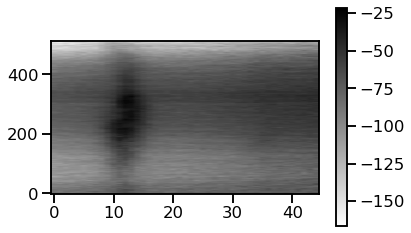

In [6]:
fig, ax = plt.subplots()
im = ax.imshow(cii_medianpv, origin="lower", cmap="gray_r")
fig.colorbar(im, ax=ax)
ax.set_aspect(0.05)

So that is the median over all slits of the PV diagram with axes in pixels. 

I can't really see any sign of that ghost at all. 

Now look at median absolute deviation (MAD) from the median:

In [7]:
cii_madpv = np.median(np.abs(cii_cube - cii_medianpv), axis=0)

Note that the main reason for using median and MAD instead of mean and sigma is to filter out the stars. 

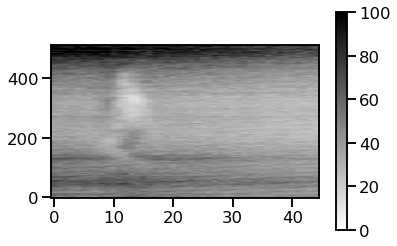

In [8]:
fig, ax = plt.subplots()
im = ax.imshow(cii_madpv, vmin=0, vmax=100, origin="lower", cmap="gray_r")
fig.colorbar(im, ax=ax)
ax.set_aspect(0.05)

Again, no sign that the ghost is giving any trouble. Let's look at the average profile versus wav pixel:

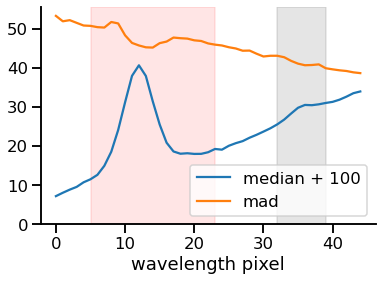

In [9]:
fig, ax = plt.subplots()
ax.plot(100 + cii_medianpv.mean(axis=0), label="median + 100")
ax.plot(cii_madpv.mean(axis=0), label="mad")
ax.axvspan(32, 39, color="k", alpha=0.1)
ax.axvspan(5, 23, color="r", alpha=0.1)
ax.legend(loc="lower right")
ax.set(
    xlabel="wavelength pixel",
    ylim=[0, None],
)
sns.despine();

Aha, now we see the ghost (gray box in figure).  If we mask out the ghosts and the C II line, then it looks like a linear fit might be adequate.

Now look at the average profile along the slit. 

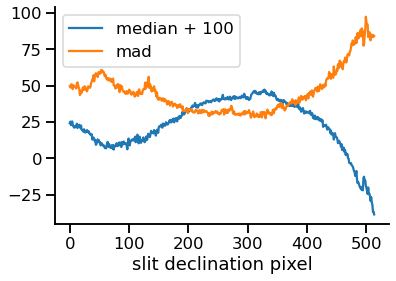

In [10]:
fig, ax = plt.subplots()
ax.plot(100 + cii_medianpv.mean(axis=1), label="median + 100")
ax.plot(cii_madpv.mean(axis=1), label="mad")
#ax.axvspan(32, 39, color="k", alpha=0.1)
#ax.axvspan(5, 23, color="r", alpha=0.1)
ax.legend(loc="upper left")
ax.set(
    xlabel="slit declination pixel",
    ylim=[None, None],
)
sns.despine();

This shows a more complicated variation, and it wouldn't be well represented by a low-order polynomial. 

## Fit the continuum regions. 

Given the above, what I will try first is to fit each spaxel separately with a linear (or maybe quadratic) function of wavelength.

In [11]:
nx, ny, nv = cii_cube.shape
vpix = np.arange(nv)

Use just the 0:5 and 22:32 range for continuum.

In [12]:
cmask = np.zeros_like(vpix, dtype=bool)
cmask[:5] = True
cmask[22:32] = True
cmask

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [13]:
NDEG = 2
cont_cube = np.empty_like(cii_cube)
coef_map = np.empty((NDEG + 1, ny, nx), dtype=float)
for i in range(nx):
    for j in range(ny):
        spec = cii_cube[i, j, :]
        p = T.fit(vpix[cmask], spec[cmask], deg=NDEG)
        coef_map[:, j, i] = p.coef
        cont_cube[i, j, :] = p(vpix)
pdomain = p.domain

The tricky bit here is that we have to keep track of the domain of the Chebyshev polynomial if we want to reconstruct the polynomial from the coefficients later.

In [14]:
map_aspect = w.wcs.cdelt[1] / w.wcs.cdelt[2]

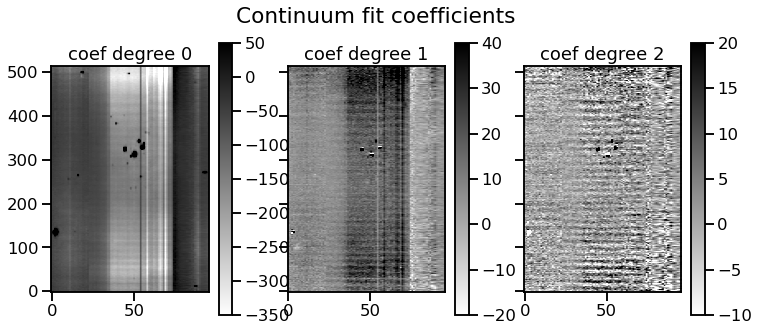

In [15]:
fig, [ax, axx, axxx] = plt.subplots(
    1, 3, 
    sharey=True, 
    figsize=(12, 5),
)
im = ax.imshow(
    coef_map[0, ...], 
    vmin=-350, vmax=50, 
    origin="lower", 
    cmap="gray_r",
)
fig.colorbar(im, ax=ax)
ax.set_aspect(map_aspect)
ax.set_title("coef degree 0")
im = axx.imshow(
    coef_map[1, ...], 
    vmin=-20, vmax=40, 
    origin="lower", 
    cmap="gray_r",
)
fig.colorbar(im, ax=axx)
axx.set_aspect(map_aspect)
axx.set_title("coef degree 1")

im = axxx.imshow(
    coef_map[2, ...], 
    vmin=-10, vmax=20, 
    origin="lower", 
    cmap="gray_r",
)
fig.colorbar(im, ax=axxx)
axxx.set_aspect(map_aspect)
axxx.set_title("coef degree 2")


fig.suptitle("Continuum fit coefficients");

So that is maps of the polynomial coefficients that fit the continuum.  We can see discontinuous jumps between sets of slits, so it is not worth fitting anything in the RA direction. 

However, in the dec direction maybe we could smooth it. It turns out that just taking the median does not work well.  So we will try a rolling median. 

In [16]:
from scipy.ndimage import median_filter

In [17]:
a = np.array([0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0])
median_filter(a, size=3)

array([0., 0., 1., 2., 2., 0., 0., 0., 0.])

In [18]:
coef_map_smooth = median_filter(
    coef_map, 
    size=(1, 50, 1)
)

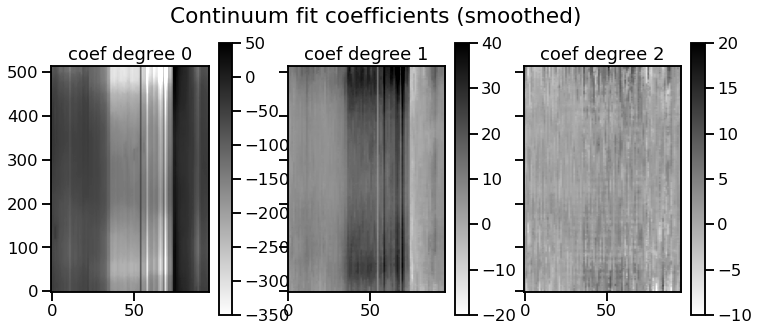

In [19]:
fig, [ax, axx, axxx] = plt.subplots(
    1, 3, 
    sharey=True, 
    figsize=(12, 5),
)
im = ax.imshow(
    coef_map_smooth[0, ...], 
    vmin=-350, vmax=50, 
    origin="lower", 
    cmap="gray_r",
)
fig.colorbar(im, ax=ax)
ax.set_aspect(map_aspect)
ax.set_title("coef degree 0")
im = axx.imshow(
    coef_map_smooth[1, ...], 
    vmin=-20, vmax=40, 
    origin="lower", 
    cmap="gray_r",
)
fig.colorbar(im, ax=axx)
axx.set_aspect(map_aspect)
axx.set_title("coef degree 1")

im = axxx.imshow(
    coef_map_smooth[2, ...], 
    vmin=-10, vmax=20, 
    origin="lower", 
    cmap="gray_r",
)
fig.colorbar(im, ax=axxx)
axxx.set_aspect(w.wcs.cdelt[1] / w.wcs.cdelt[2])
axxx.set_title("coef degree 2")


fig.suptitle("Continuum fit coefficients (smoothed)");

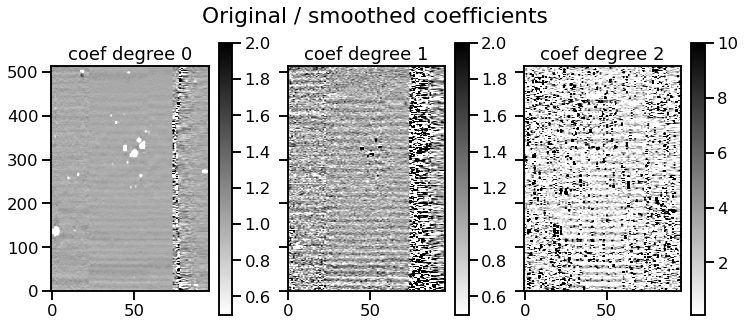

In [20]:
fig, [ax, axx, axxx] = plt.subplots(
    1, 3, 
    sharey=True, 
    figsize=(12, 5),
)
im = ax.imshow(
    coef_map[0, ...] / coef_map_smooth[0, ...], 
    vmin=0.5, vmax=2, 
    origin="lower", 
    cmap="gray_r",
)
fig.colorbar(im, ax=ax)
ax.set_aspect(map_aspect)
ax.set_title("coef degree 0")
im = axx.imshow(
    coef_map[1, ...] / coef_map_smooth[1, ...], 
    vmin=0.5, vmax=2, 
    origin="lower", 
    cmap="gray_r",
)
fig.colorbar(im, ax=axx)
axx.set_aspect(map_aspect)
axx.set_title("coef degree 1")

im = axxx.imshow(
    coef_map[2, ...] / coef_map_smooth[2, ...], 
    vmin=0.1, vmax=10, 
    origin="lower", 
    cmap="gray_r",
)
fig.colorbar(im, ax=axxx)
axxx.set_aspect(map_aspect)
axxx.set_title("coef degree 2")


fig.suptitle("Original / smoothed coefficients");

In [21]:
cont_cube_smooth = np.empty_like(cont_cube)
for i in range(nx):
    for j in range(ny):
        p = T(
            coef_map_smooth[:, j, i], 
            domain=pdomain
        )
        cont_cube_smooth[i, j, :] = p(vpix)

In [22]:
cont_cube_smooth2 = np.median(
    cont_cube, 
    axis=1, 
    keepdims=True,
) * np.ones_like(cont_cube)

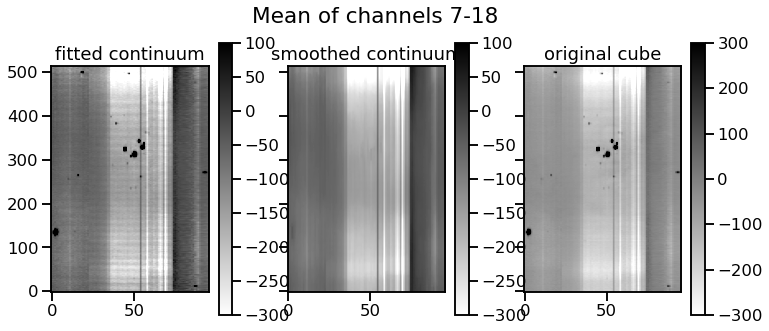

In [23]:
fig, [ax, axx, axxx] = plt.subplots(
    1, 3, 
    sharey=True, 
    figsize=(12, 5),
)
im = ax.imshow(
    np.mean(cont_cube[:, :, 7:18], axis=-1).T, 
    vmin=-300, vmax=100, 
    origin="lower", 
    cmap="gray_r",
)
fig.colorbar(im, ax=ax)
ax.set_aspect(map_aspect)
ax.set_title("fitted continuum")
im = axx.imshow(
    np.mean(cont_cube_smooth[:, :, 7:18], axis=-1).T, 
    vmin=-300, vmax=100, 
    origin="lower", 
    cmap="gray_r",
)
fig.colorbar(im, ax=axx)
axx.set_aspect(map_aspect)
axx.set_title("smoothed continuum")

im = axxx.imshow(
    np.mean(cii_cube[:, :, 7:18], axis=-1).T, 
    vmin=-300, vmax=300, 
    origin="lower", 
    cmap="gray_r",
)
fig.colorbar(im, ax=axxx)
axxx.set_aspect(map_aspect)
axxx.set_title("original cube")


fig.suptitle("Mean of channels 7-18");

## Subtract continuum to get the line map

In [24]:
cii_cube_csub = cii_cube - cont_cube_smooth

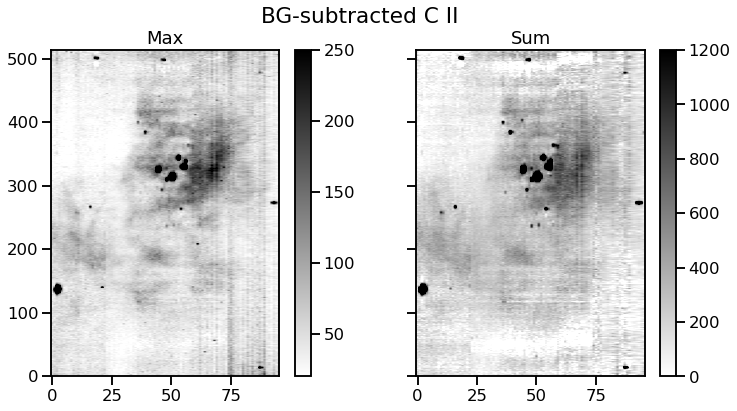

In [25]:
fig, axes = plt.subplots(
    1, 2,
    sharey=True,
    figsize=(12, 6),
)
im = axes[0].imshow(
    np.max(cii_cube_csub, axis=-1).T, 
    vmin=20, vmax=250, 
    origin="lower", 
    cmap="gray_r",
)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Max")

im = axes[1].imshow(
    np.sum(cii_cube_csub[:, :, 6:20], axis=-1).T, 
    vmin=0, vmax=1200, 
    origin="lower", 
    cmap="gray_r",
)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Sum")

for ax in axes:
    ax.set_aspect(map_aspect)

fig.suptitle("BG-subtracted C II");

## Separate velocity channels

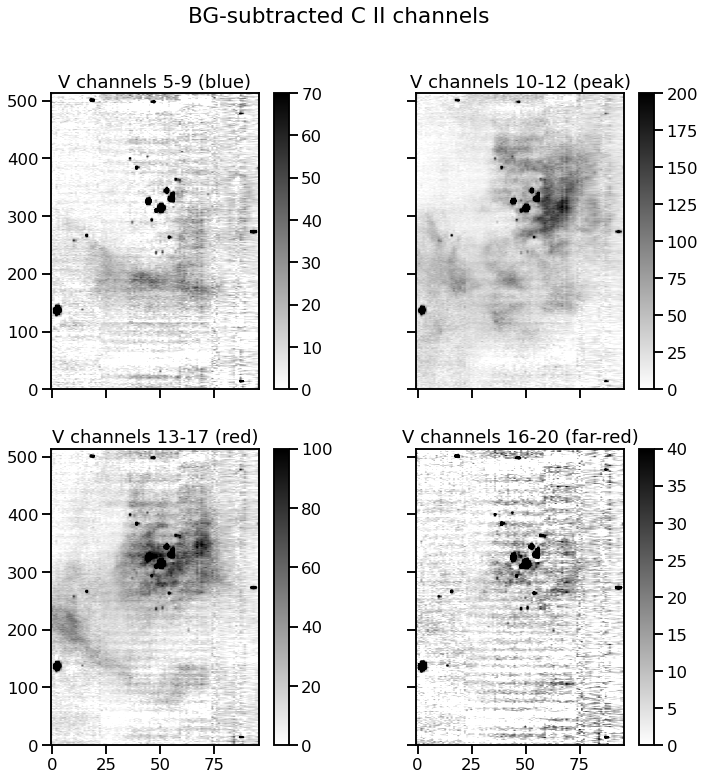

In [26]:
fig, axes = plt.subplots(
    2, 2,
    sharex=True,
    sharey=True,
    figsize=(12, 12),
)

chan_maps = {}

for s, kk, fmax, ax in zip(
    ["blue", "peak", "red", "far-red"],
    [[5, 9], [10, 12], [13, 17], [16, 20]],
    [70, 200, 100, 40],
    axes.flat,
):
    k1, k2 = kk
    chan_maps[s] = np.mean(cii_cube_csub[..., k1:k2 + 1], axis=-1).T
    im = ax.imshow(
        chan_maps[s], 
        vmin=0, vmax=fmax, 
        origin="lower", 
        cmap="gray_r",
    )
    fig.colorbar(im, ax=ax)
    ax.set_title(f"V channels {k1}-{k2} ({s})")

for ax in axes.flat:
    ax.set_aspect(map_aspect)

fig.suptitle("BG-subtracted C II channels");

Combine into a color image

In [27]:
rgbim = np.empty((ny, nx, 3), dtype=float)
rgbim[..., 0] = chan_maps["red"] / 80
rgbim[..., 1] = chan_maps["peak"] / 160
rgbim[..., 2] = chan_maps["blue"] / 50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


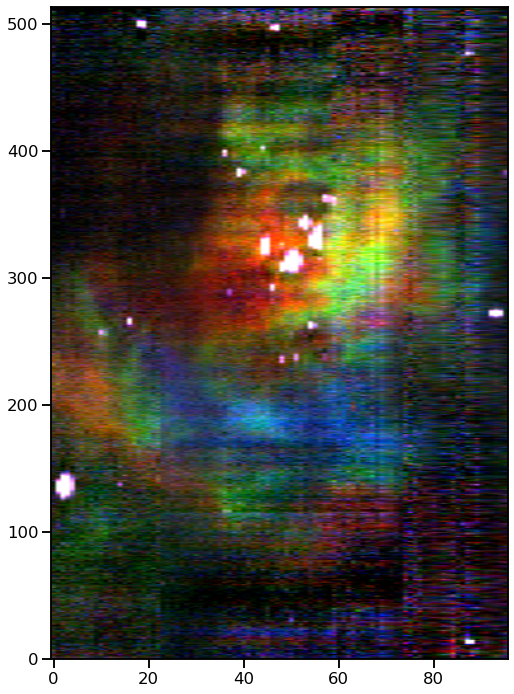

In [28]:
fig, ax = plt.subplots(
    figsize=(12, 12),
)
ax.imshow(rgbim, origin="lower")
ax.set_aspect(map_aspect);

That looks remarkably like the [O III] channel map!

## Comparison with other lines

In [29]:
hdu_ha = fits.open(RAW_DATA_PATH / "vstack.ha.fits")[0]
wha = WCS(hdu_ha.header)
wha

WCS Keywords

Number of WCS axes: 3
CTYPE : 'velocity'  'pos'  'pos'  
CRVAL : 18.0  0.0  0.0  
CRPIX : 76.0  315.0  51.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 4.0  0.534  2.0  
NAXIS : 151  514  96

In [30]:
hdu_o3 = fits.open(RAW_DATA_PATH / "vstack.oiii.fits")[0]
wo3 = WCS(hdu_o3.header)
wo3

WCS Keywords

Number of WCS axes: 3
CTYPE : 'velocity'  'pos'  'pos'  
CRVAL : 18.0  0.0  0.0  
CRPIX : 101.0  315.0  51.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 4.0  0.534  2.0  
NAXIS : 201  514  96

So H alpha has the same data shape as [N II], but [O III] has more pixels in the spectral axis.

In [31]:
ha_cube = hdu_ha.data
oiii_cube = hdu_o3.data
ha_medianpv = np.median(ha_cube, axis=0)
oiii_medianpv = np.median(oiii_cube, axis=0)

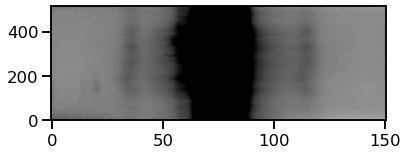

In [32]:
fig, ax = plt.subplots()
ax.imshow(ha_medianpv, vmin=-30, vmax=30, origin="lower", cmap="gray_r")
ax.set_aspect(0.1)

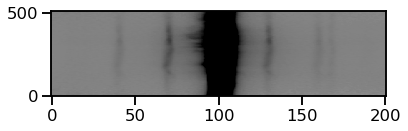

In [33]:
fig, ax = plt.subplots()
ax.imshow(oiii_medianpv, vmin=-30, vmax=30, origin="lower", cmap="gray_r")
ax.set_aspect(0.1)

In [34]:
ha_map = np.max(ha_cube[..., 50:100], axis=-1).T
oiii_map = np.max(oiii_cube[..., 50:100], axis=-1).T

Switch over to using the maximum of each line profile.  This improves the signal-to-noise ratio of the C II line.

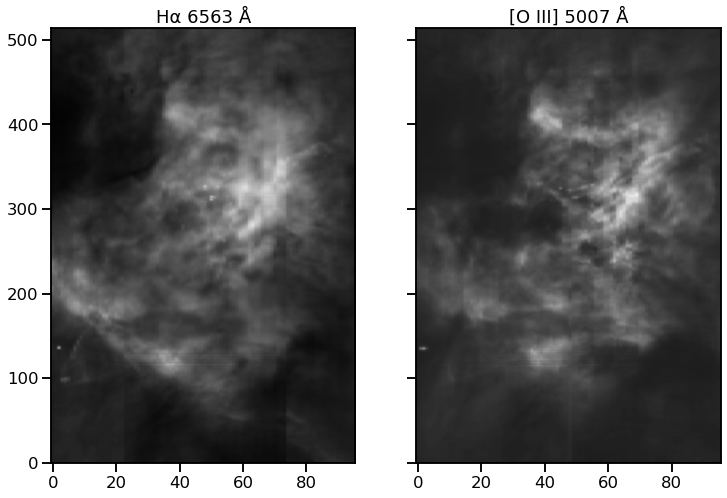

In [35]:
fig, axes = plt.subplots(
    1, 2,
    sharex=True,
    sharey=True,
    figsize=(12, 8),
)

axes[0].imshow(
    ha_map, 
    origin="lower", 
    vmin=0, vmax=5*np.median(ha_map), 
    cmap="gray",
)
axes[0].set_title("Hα 6563 Å")

axes[1].imshow(
    oiii_map, 
    origin="lower", 
    vmin=-np.median(oiii_map), vmax=9*np.median(oiii_map), 
    cmap="gray",
)
axes[1].set_title("[O III] 5007 Å")



for ax in axes:
    ax.set_aspect(map_aspect)




In [36]:
cii_map = np.max(cii_cube_csub[:, :, 5:20], axis=-1).T

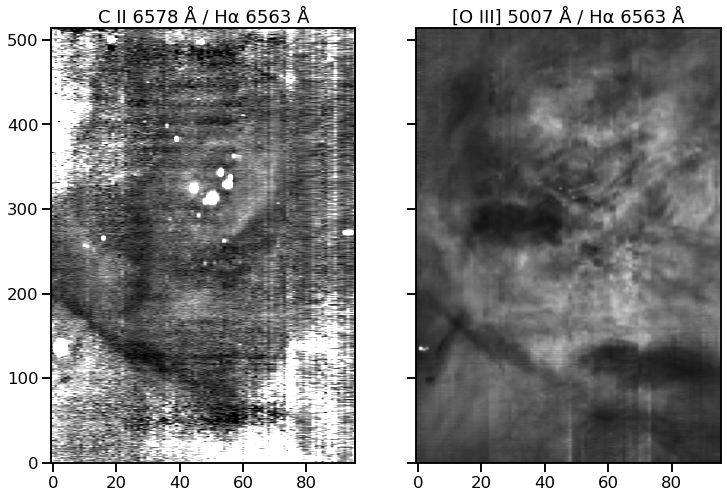

In [37]:
fig, axes = plt.subplots(
    1, 2,
    sharex=True,
    sharey=True,
    figsize=(12, 8),
)

faintmask = cii_map < 0.01 * np.median(cii_map)
ratio = cii_map / ha_map
#ratio[faintmask] = np.nan
axes[0].imshow(
    ratio, 
    origin="lower", 
    vmin=0.002, vmax=0.01, 
    cmap="gray",
)
axes[0].set_title("C II 6578 Å / Hα 6563 Å")

axes[1].imshow(
    oiii_map / ha_map, 
    origin="lower", 
    vmin=0, vmax=1.0, 
    cmap="gray",
)
axes[1].set_title("[O III] 5007 Å / Hα 6563 Å")



for ax in axes:
    ax.set_aspect(map_aspect)

This map of C II / Ha does look somewhat similar to the MUSE one of 7236 / Ha.  So maybe there is some fluorescence going on here.  We will have to compare it with the C II recombination lines to be sure.

With [O III] / Ha there may be some effect of extinction. 

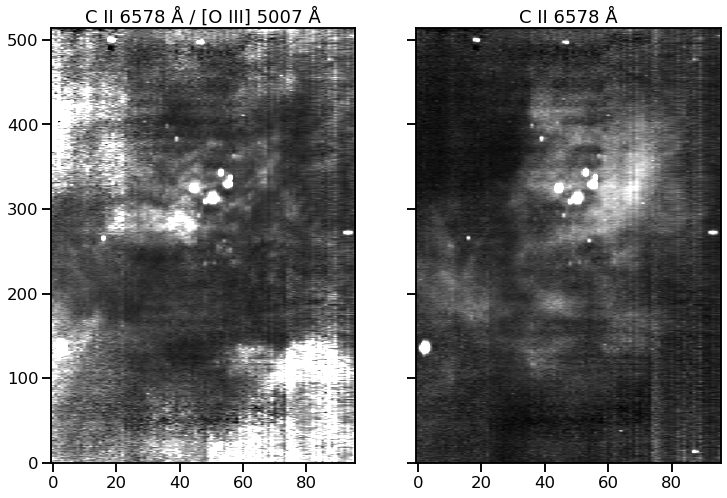

In [38]:
fig, axes = plt.subplots(
    1, 2,
    sharex=True,
    sharey=True,
    figsize=(12, 8),
)
ratio = cii_map / oiii_map
#ratio[faintmask] = np.nan
axes[0].imshow(
    ratio, 
    origin="lower", 
    vmin=0, vmax=0.05, 
    cmap="gray",
)
axes[0].set_title("C II 6578 Å / [O III] 5007 Å")

axes[1].imshow(
    cii_map, 
    origin="lower", 
    vmin=0, vmax=5 * np.median(cii_map), 
    cmap="gray",
)
axes[1].set_title("C II 6578 Å")



for ax in axes:
    ax.set_aspect(map_aspect)
pass;

This looks very strange, And not at all like I was expecting based on the 7236 line. 

Bear in mind though that a lot of the positive structure is more driven by holes in the [O III] than by excess of C II. Also, the extinction must be affecting things too.

# Look at selected parts of the oiii cube

Now we will use the resampled cubes that we have already calculated WCS and BG subtraction for from the Luis project:

In [39]:
LUIS_DATA_PATH = Path.home() / "Dropbox" / "LuisBowshocks" / "kinematics"

In [40]:
o3cube_hdu = fits.open(LUIS_DATA_PATH / "vcube.oiii-wcs-csub.fits")[0]

Write out a version that is normalised to give the fraction of the integrated emission in each channel. 

In [42]:
fits.PrimaryHDU(
    header=o3cube_hdu.header,
    data=o3cube_hdu.data / np.sum(o3cube_hdu.data, axis=0)
).writeto(
    LUIS_DATA_PATH / "vcube.oiii-wcs-csub-frac.fits",
    overwrite=True,
)

Save selected pairs of channels that trace the Trapezium shell and the Big Arc

First the Trapezium shell: 

In [43]:
o3_Vp32 = np.sum(o3cube_hdu.data[34 - 1:36 + 1, ...], axis=0)
o3_Vp24 = np.sum(o3cube_hdu.data[32 - 1:34 + 1, ...], axis=0)
o3_Vp16 = np.sum(o3cube_hdu.data[30 - 1:32 + 1, ...], axis=0)

In [44]:
nv, ny, nx = o3cube_hdu.data.shape
rgbim = np.empty((ny, nx, 3), dtype=float)
norm = 0.14
rgbim[..., 0] = norm * o3_Vp32 / np.median(o3_Vp32)
rgbim[..., 1] = norm * o3_Vp24 / np.median(o3_Vp24)
rgbim[..., 2] = norm * o3_Vp16 / np.median(o3_Vp16)

Now the Big Arc:

In [45]:
o3_Vp08 = np.sum(o3cube_hdu.data[28 - 1:30 + 1, ...], axis=0)
o3_Vp00 = np.sum(o3cube_hdu.data[26 - 1:28 + 1, ...], axis=0)
o3_Vn08 = np.sum(o3cube_hdu.data[24 - 1:26 + 1, ...], axis=0)

In [46]:
rgbim2 = np.empty((ny, nx, 3), dtype=float)
norm2 = 0.14
rgbim2[..., 0] = norm2 * o3_Vp08 / np.median(o3_Vp08)
rgbim2[..., 1] = norm2 * o3_Vp00 / np.median(o3_Vp00)
rgbim2[..., 2] = norm2 * o3_Vn08 / np.median(o3_Vn08)

Plot them both together:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


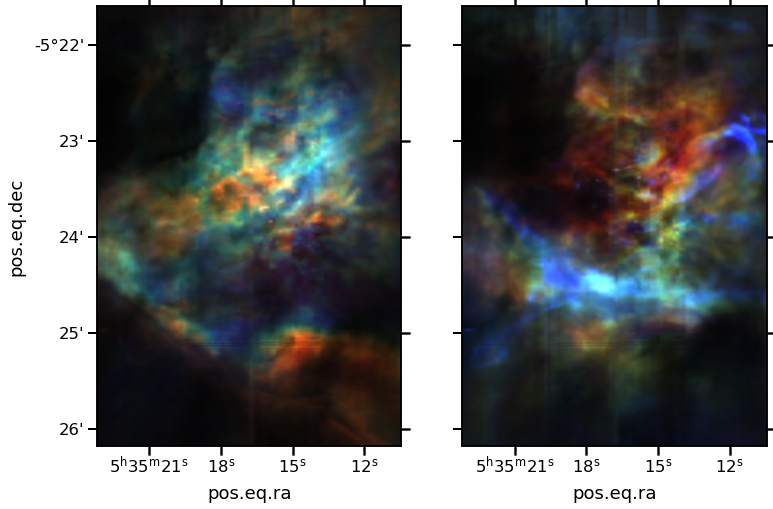

In [47]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 10),
    subplot_kw=dict(projection=WCS(o3cube_hdu.header).celestial),
    sharex=True,
    sharey=True,
)
axes[0].imshow(rgbim)
axes[1].imshow(rgbim2)
axes[1].coords[1].set_ticklabel_visible(False)
axes[1].coords[1].set_axislabel("")
...;

In [50]:
o3_Vp80 = np.sum(o3cube_hdu.data[46 - 1:48 + 1, ...], axis=0)
o3_Vp72 = np.sum(o3cube_hdu.data[44 - 1:46 + 1, ...], axis=0)
o3_Vp64 = np.sum(o3cube_hdu.data[42 - 1:44 + 1, ...], axis=0)

o3_Vp56 = np.sum(o3cube_hdu.data[40 - 1:42 + 1, ...], axis=0)
o3_Vp48 = np.sum(o3cube_hdu.data[38 - 1:40 + 1, ...], axis=0)
o3_Vp40 = np.sum(o3cube_hdu.data[36 - 1:38 + 1, ...], axis=0)

o3_Vn16 = np.sum(o3cube_hdu.data[22 - 1:24 + 1, ...], axis=0)
o3_Vn24 = np.sum(o3cube_hdu.data[20 - 1:22 + 1, ...], axis=0)
o3_Vn32 = np.sum(o3cube_hdu.data[18 - 1:20 + 1, ...], axis=0)

o3_Vn40 = np.sum(o3cube_hdu.data[16 - 1:18 + 1, ...], axis=0)
o3_Vn48 = np.sum(o3cube_hdu.data[14 - 1:16 + 1, ...], axis=0)
o3_Vn56 = np.sum(o3cube_hdu.data[12 - 1:24 + 1, ...], axis=0)

o3_Vn64 = np.sum(o3cube_hdu.data[10 - 1:12 + 1, ...], axis=0)
o3_Vn72 = np.sum(o3cube_hdu.data[8 - 1:10 + 1, ...], axis=0)
o3_Vn80 = np.sum(o3cube_hdu.data[6 - 1:8 + 1, ...], axis=0)



rgbim7 = np.empty((ny, nx, 3), dtype=float)
norm7 = 0.16
rgbim7[..., 0] = norm7 * o3_Vp80 / np.median(o3_Vp80)
rgbim7[..., 1] = norm7 * o3_Vp72 / np.median(o3_Vp72)
rgbim7[..., 2] = norm7 * o3_Vp64 / np.median(o3_Vp64)
rgbim3 = np.empty((ny, nx, 3), dtype=float)
norm3 = 0.16
rgbim3[..., 0] = norm3 * o3_Vp56 / np.median(o3_Vp56)
rgbim3[..., 1] = norm3 * o3_Vp48 / np.median(o3_Vp48)
rgbim3[..., 2] = norm3 * o3_Vp40 / np.median(o3_Vp40)
rgbim4 = np.empty((ny, nx, 3), dtype=float)
norm4 = 0.1
rgbim4[..., 0] = norm4 * o3_Vn16 / np.median(o3_Vn16)
rgbim4[..., 1] = norm4 * o3_Vn24 / np.median(o3_Vn24)
rgbim4[..., 2] = norm4 * o3_Vn32 / np.median(o3_Vn32)
rgbim5 = np.empty((ny, nx, 3), dtype=float)
norm5 = 0.05
rgbim5[..., 0] = norm5 * o3_Vn40 / np.median(o3_Vn40)
rgbim5[..., 1] = norm5 * o3_Vn48 / np.median(o3_Vn48)
rgbim5[..., 2] = norm5 * o3_Vn56 / np.median(o3_Vn56)
rgbim6 = np.empty((ny, nx, 3), dtype=float)
norm6 = 0.05
rgbim6[..., 0] = norm6 * o3_Vn64 / np.median(o3_Vn64)
rgbim6[..., 1] = norm6 * o3_Vn72 / np.median(o3_Vn72)
rgbim6[..., 2] = norm6 * o3_Vn80 / np.median(o3_Vn80)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


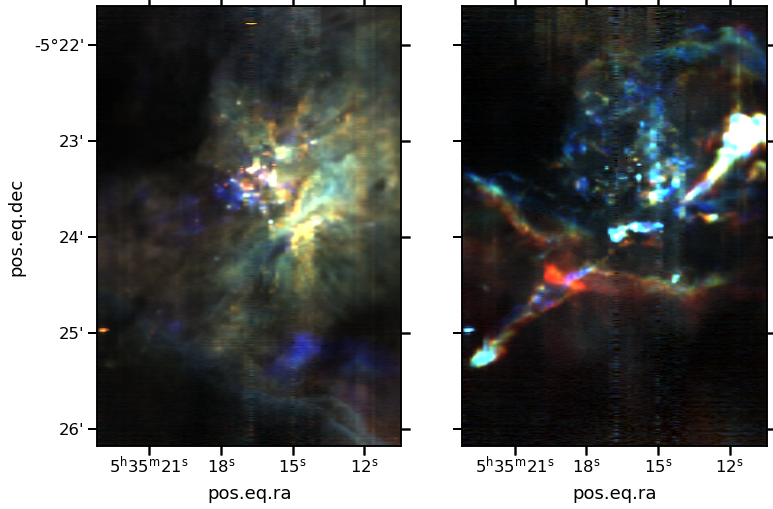

In [51]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 10),
    subplot_kw=dict(projection=WCS(o3cube_hdu.header).celestial),
    sharex=True,
    sharey=True,
)
axes[0].imshow(rgbim3)
axes[1].imshow(rgbim4)
axes[1].coords[1].set_ticklabel_visible(False)
axes[1].coords[1].set_axislabel("")
...;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


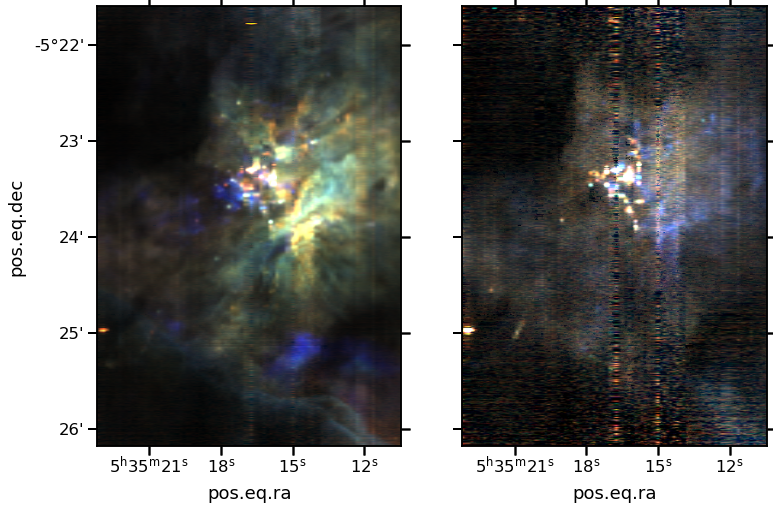

In [52]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 10),
    subplot_kw=dict(projection=WCS(o3cube_hdu.header).celestial),
    sharex=True,
    sharey=True,
)
axes[0].imshow(rgbim3)
axes[1].imshow(rgbim7)
axes[1].coords[1].set_ticklabel_visible(False)
axes[1].coords[1].set_axislabel("")
...;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


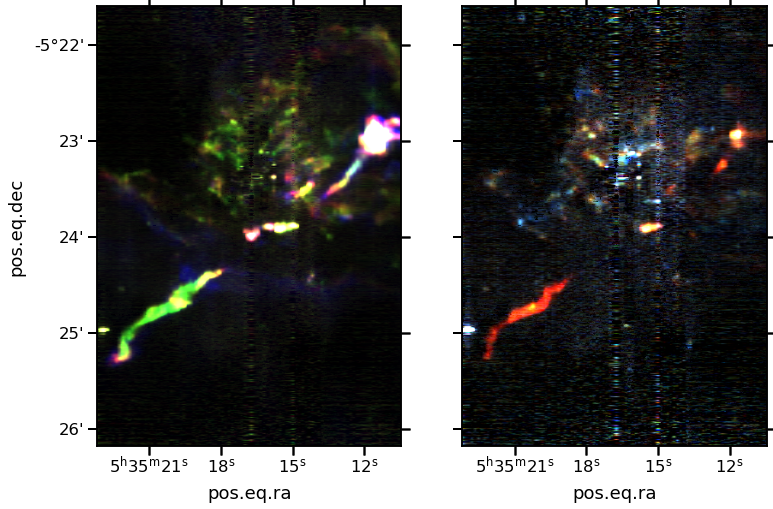

In [53]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 10),
    subplot_kw=dict(projection=WCS(o3cube_hdu.header).celestial),
    sharex=True,
    sharey=True,
)
axes[0].imshow(rgbim5)
axes[1].imshow(rgbim6)
axes[1].coords[1].set_ticklabel_visible(False)
axes[1].coords[1].set_axislabel("")
...;

In [55]:
from astropy.coordinates import SkyCoord
import astropy.units as u

Coordinates of th1C

In [56]:
c0 = SkyCoord(ra=83.81859898, dec=-5.38968015, unit=u.deg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


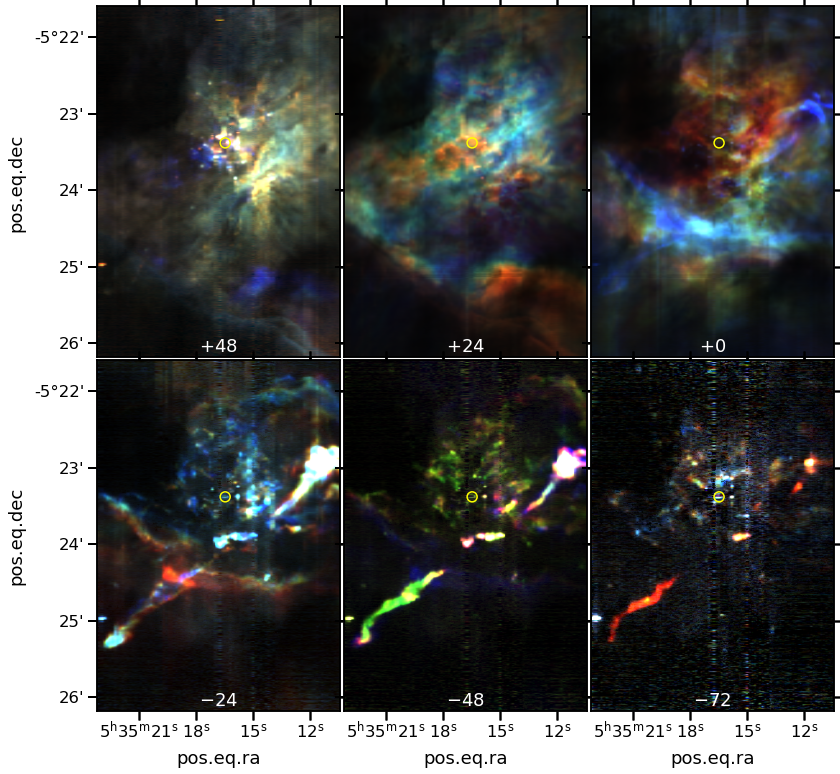

In [500]:
fig, axes = plt.subplots(
    2, 3, 
    figsize=(12, 11.1),
    subplot_kw=dict(projection=WCS(o3cube_hdu.header).celestial),
    sharex=True,
    sharey=True,
    constrained_layout=False,
)
axes[0, 0].imshow(rgbim3)
axes[0, 0].set_title("$+48$", y=0, color="w")
axes[0, 1].imshow(rgbim)
axes[0, 1].set_title("$+24$", y=0, color="w")
axes[0, 2].imshow(rgbim2)
axes[0, 2].set_title("$+0$", y=0, color="w")
axes[1, 0].imshow(rgbim4)
axes[1, 0].set_title("$-24$", y=0, color="w")
axes[1, 1].imshow(rgbim5)
axes[1, 1].set_title("$-48$", y=0, color="w")
axes[1, 2].imshow(rgbim6)
axes[1, 2].set_title("$-72$", y=0, color="w")
for ax in axes[:, 1:].flat:
    ax.coords[1].set_ticklabel_visible(False)
    ax.coords[1].set_axislabel("")
for ax in axes[0, :].flat:
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[0].set_axislabel("")
for ax in axes.flat:
    ax.scatter(
        c0.ra.deg, c0.dec.deg, 
        transform=ax.get_transform("icrs"), 
        s=100, 
        ec="yellow", 
        fc="none",
    )
fig.canvas.draw()
fig.tight_layout(h_pad=0.2, w_pad=0.1)
#fig.tight_layout(
#    pad=8.0,  h_pad=0, w_pad=0, 
#    rect=[0.0, 1.2, 0.0, 1.2],
#)
#fig.set_constrained_layout_pads(w_pad=1, h_pad=1)
fig.savefig("../figs/multi-isovel-oiii.pdf")
...;

In [495]:
fig.set

These nicely show the Trapezium shell, which has a smoothish appearance on the red side (e.g., red-green transition in the upper middle pane). But is much more fragmented on blue side. See bottom panels. 

Radius of each pixel from th1C

In [226]:
wcube = WCS(o3cube_hdu.header).celestial
ii, jj = np.meshgrid(range(nx), range(ny))
c = wcube.array_index_to_world(jj, ii)
rad = c.separation(c0).arcsec
rad.min(), rad.mean(), rad.max()

(0.3067979732147547, 93.01620148850257, 194.9947874882855)

In [229]:
wspec = WCS(o3cube_hdu.header).spectral
vels = wspec.array_index_to_world(range(nv)).value
vels

array([-102.,  -98.,  -94.,  -90.,  -86.,  -82.,  -78.,  -74.,  -70.,
        -66.,  -62.,  -58.,  -54.,  -50.,  -46.,  -42.,  -38.,  -34.,
        -30.,  -26.,  -22.,  -18.,  -14.,  -10.,   -6.,   -2.,    2.,
          6.,   10.,   14.,   18.,   22.,   26.,   30.,   34.,   38.,
         42.,   46.,   50.,   54.,   58.,   62.,   66.,   70.,   74.,
         78.,   82.,   86.,   90.,   94.,   98.,  102.,  106.,  110.,
        114.,  118.,  122.,  126.,  130.,  134.,  138.])

We need to mask out th2A since its continuum dominates some of the farther out velocity channels.

In [230]:
c0_2A = SkyCoord(ra= 83.84542605, dec=-5.41606033, unit=u.deg)
rad2A = c.separation(c0_2A).arcsec
m2A = rad2A < 3.0

Make a histogram of velocity profile versus radius:

In [265]:
hists = []
edges = []
for plane in o3cube_hdu.data:
    mgood = ~m2A
    #mgood[:, 170:190] = False
    #mgood[:, 220:240] = False
    mgood = mgood & np.isfinite(plane)
    mgood = mgood & (plane > 0.0)
    #mgood = mgood & (plane < 300 * np.nanmean(plane))
    H, e = np.histogram(
        rad[mgood], 
        weights=plane[mgood] / rad[mgood], 
        density=False,
        bins=np.linspace(0.0, 180.0, 200),
    )
    hists.append(
        H #/ np.nanmax(H)
    )
hist_arr = np.stack(hists)
hist_arr /= np.nanmedian(hist_arr)
#hist_arr -= np.median(hist_arr[:, :10], axis=1, keepdims=True)

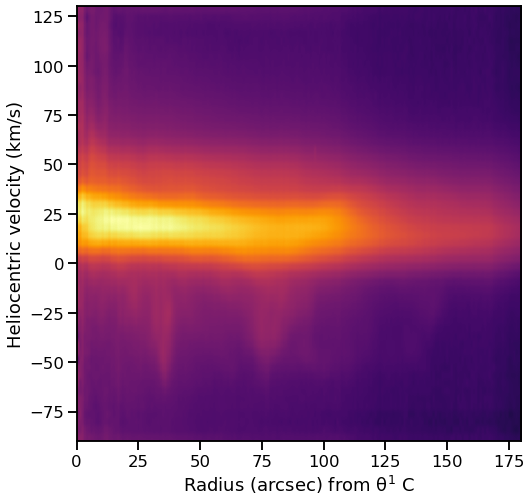

In [266]:
fig, ax = plt.subplots(figsize=(12,8))
gamma = 6.0
ax.imshow(
    hist_arr**(1/gamma), 
    origin="lower",
    extent=[e[0], e[-1], vels[0], vels[-1]],
    vmin=0, vmax=None,
    cmap="inferno",
)
ax.set_aspect(0.8)
ax.set(
    ylim=[-90, 130],
    xlabel="Radius (arcsec) from θ$^1$ C",
    ylabel="Heliocentric velocity (km/s)",
)
...;

Now try against log radius to accentuate the Trapezium shell:

<ipython-input-280-68e8fbafd677>:25: RuntimeWarning: invalid value encountered in true_divide
  vmeans = mom1 / mom0


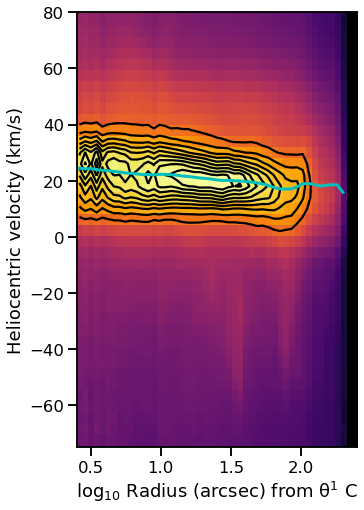

In [280]:
hists = []
edges = []
for plane in o3cube_hdu.data:
    mgood = ~m2A
    #mgood[:, 170:190] = False
    #mgood[:, 220:240] = False
    mgood = mgood & np.isfinite(plane)
    mgood = mgood & (plane > 0.0)
    #mgood = mgood & (plane < 300 * np.nanmean(plane))
    H, e = np.histogram(
        np.log10(rad[mgood]), 
        weights=plane[mgood] / rad[mgood]**2, 
        density=False,
        bins=np.linspace(0.4, 2.4, 50),
    )
    hists.append(
        H #/ np.nanmax(H)
    )
hist_arr = np.stack(hists)
hist_arr /= np.nanmedian(hist_arr)

vslice = slice(25, 38)
mom0 = np.sum(hist_arr[vslice, :], axis=0)
mom1 = np.sum(hist_arr[vslice, :] * vels[vslice, None], axis=0)
vmeans = mom1 / mom0

fig, ax = plt.subplots(figsize=(12,8))
gamma = 6.0
ax.imshow(
    hist_arr**(1/gamma), 
    origin="lower",
    extent=[e[0], e[-1], vels[0], vels[-1]],
    vmin=0, vmax=None,
    cmap="inferno",
)
centers = 0.5 * (e[1:] + e[:-1])
ax.contour(
    centers,
    vels,
    hist_arr / hist_arr.max(), 
    levels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    colors="k",
)
ax.plot(centers, vmeans, color="c", lw=3)

ax.set_aspect(0.02)
ax.set(
    ylim=[-75, 80],
    xlabel="log$_{10}$ Radius (arcsec) from θ$^1$ C",
    ylabel="Heliocentric velocity (km/s)"
)
...;

<ipython-input-307-877fff836360>:31: RuntimeWarning: invalid value encountered in true_divide
  vmeans = mom1 / mom0


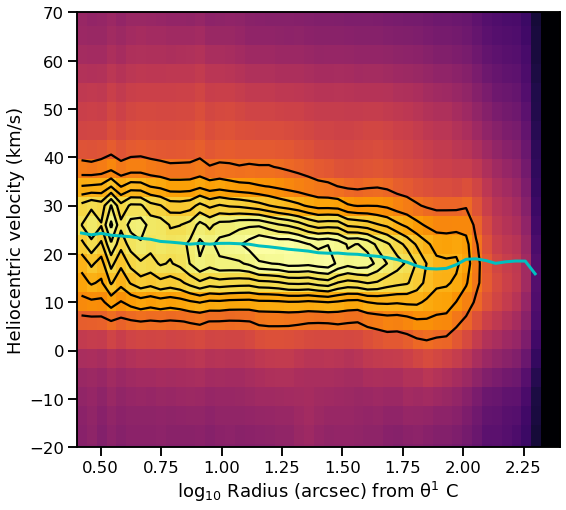

In [307]:
hists = []
edges = []
hvmap = o3cube_hdu.data[:22, ...].sum(axis=0)
hvmask = hvmap >= 15.0 * np.median(hvmap)
hvrmap = o3cube_hdu.data[42:50, ...].sum(axis=0)
hvmask = hvmask | (hvrmap >= 15.0 * np.median(hvrmap))


for plane in o3cube_hdu.data:
    mgood = (~m2A) & (~hvmask)
    #mgood[:, 170:190] = False
    #mgood[:, 220:240] = False
    mgood = mgood & np.isfinite(plane)
    mgood = mgood & (plane > 0.0)
    #mgood = mgood & (plane < 300 * np.nanmean(plane))
    H, e = np.histogram(
        np.log10(rad[mgood]), 
        weights=plane[mgood] / rad[mgood]**2, 
        density=False,
        bins=np.linspace(0.4, 2.4, 50),
    )
    hists.append(
        H #/ np.nanmax(H)
    )
hist_arr = np.stack(hists)
hist_arr /= np.nanmedian(hist_arr)

vslice = slice(25, 38)
mom0 = np.sum(hist_arr[vslice, :], axis=0)
mom1 = np.sum(hist_arr[vslice, :] * vels[vslice, None], axis=0)
vmeans = mom1 / mom0


fig, ax = plt.subplots(figsize=(12,8))
gamma = 6.0
ax.imshow(
    hist_arr**(1/gamma), 
    origin="lower",
    extent=[e[0], e[-1], vels[0], vels[-1]],
    vmin=0, vmax=None,
    cmap="inferno",
)
centers = 0.5 * (e[1:] + e[:-1])
ax.contour(
    centers,
    vels,
    hist_arr / hist_arr.max(), 
    levels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    colors="k",
)
ax.plot(centers, vmeans, color="c", lw=3)

ax.set_aspect(0.02)
ax.set(
    ylim=[-20, 70],
    xlabel="log$_{10}$ Radius (arcsec) from θ$^1$ C",
    ylabel="Heliocentric velocity (km/s)"
)
...;

Here is what we are masking out:

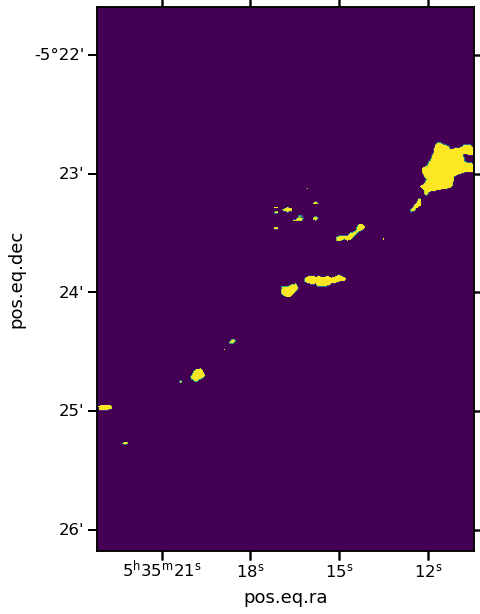

In [308]:
fig, ax = plt.subplots( 
    figsize=(8, 10),
    subplot_kw=dict(projection=WCS(o3cube_hdu.header).celestial),
    sharex=True,
    sharey=True,
)
ax.imshow(hvmask)
...;

Then try again with linear scale and normalize so that total line is equal at each radius

<ipython-input-473-b8ce7412bedd>:20: RuntimeWarning: invalid value encountered in true_divide
  H / H0,


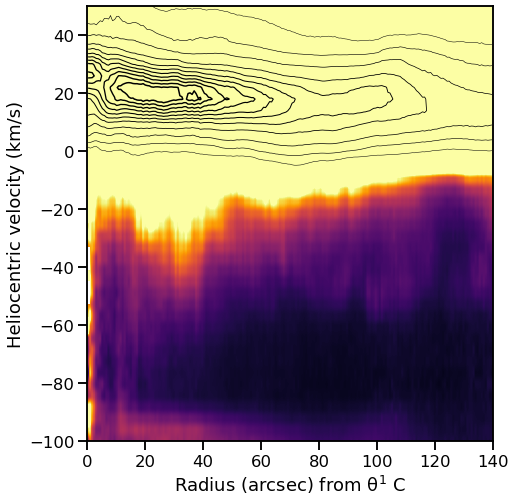

In [473]:
hists = []
edges = []
for plane in o3cube_hdu.data:
    mgood = (~m2A) & (~hvmask)
    #mgood[:, 170:190] = False
    #mgood[:, 220:240] = False
    mgood = mgood & np.isfinite(plane)
    mgood = mgood & (plane > 0.0)
    #mgood = mgood & (plane < 300 * np.nanmean(plane))
    H, e = np.histogram(
        rad[mgood], 
        weights=plane[mgood],
        bins=np.linspace(0.0, 140.0, 200),
    )
    H0, _ = np.histogram(
        rad[mgood], 
        bins=np.linspace(0.0, 140.0, 200),
    )
    hists.append(
        H / H0,
    )
hist_arr = np.stack(hists)
hist_arr /= np.nanmax(hist_arr)

vslice = slice(25, 38)
mom0 = np.sum(hist_arr[vslice, :], axis=0)
mom1 = np.sum(hist_arr[vslice, :] * vels[vslice, None], axis=0)
vmeans = mom1 / mom0



fig, ax = plt.subplots(figsize=(12,8))
gamma = 6.0
ax.imshow(
    300 * hist_arr, 
    origin="lower",
    extent=[e[0], e[-1], vels[0], vels[-1]],
    vmin=0, vmax=1.0,
    cmap="inferno",
)
centers = 0.5 * (e[1:] + e[:-1])
levels = [0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ax.contour(
    centers,
    vels,
    hist_arr, 
    levels=levels,
    colors="k",
    linewidths=0.5 + 0.1*np.arange(len(levels)),
)
#ax.plot(centers, vmeans, color="c", lw=3)
ax.set_aspect(1.)
ax.set(
    ylim=[-100, 50],
    xlabel="Radius (arcsec) from θ$^1$ C",
    ylabel="Heliocentric velocity (km/s)",
)
...;

## Look at CO velocity for point of reference



In [456]:
CO_PATH = Path.home() / "Dropbox/OrionMolecular/Carma-NRO-CO/dataverse_files"
mom1_13co_hdu = fits.open(CO_PATH / "mom1_12co_pix_2_Tmb.fits")[0]
w_13co = WCS(mom1_13co_hdu.header).celestial
vel_13co = mom1_13co_hdu.data[0, :, :]

In [457]:
ny, nx = vel_13co.shape
ii, jj = np.meshgrid(range(nx), range(ny))
c_co = w_13co.array_index_to_world(jj, ii)
rad_co = c_co.separation(c0).arcsec
rad_co.min(), rad_co.mean(), rad_co.max()

(0.14054103207218685, 3244.7890954383333, 7200.797862448022)

In [458]:
w_13co

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 83.9000372262  -5.86858782674  
CRPIX : 1455.0  2364.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.000555555576728  0.000555555576728  
NAXIS : 2557  4273

In [459]:
pa = c0.position_angle(c_co)
mNE = pa < 90 * u.deg
mSE = (pa >= 90 * u.deg) & (pa < 180 * u.deg)
mSW = (pa >= 180 * u.deg) & (pa < 270 * u.deg)
mNW = pa >= 270 * u.deg

In [460]:
quadmasks_co = {"NE": mNE, "NW": mNW, "SE": mSE, "SW": mSW}
radbins_co = np.linspace(0.0, 170.0, 86)

In [461]:
Vco_dict = {}
for qlabel, qmask in quadmasks_co.items():
    mgood = qmask
    mgood = mgood & np.isfinite(vel_13co)

    H, e = np.histogram(
        rad_co[mgood], 
        weights=vel_13co[mgood], 
        bins=radbins_co,
    )
    H0, _ = np.histogram(
        rad_co[mgood], 
        bins=radbins_co,
    )
    Vco_dict[qlabel] = 18.1 + H / H0

<ipython-input-461-b8c49e949b11>:15: RuntimeWarning: invalid value encountered in true_divide
  Vco_dict[qlabel] = 18.1 + H / H0


In [462]:
centers_co = 0.5 * (radbins_co[1:] + radbins_co[:-1])

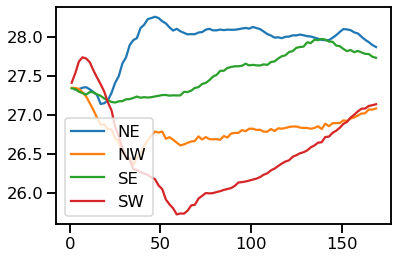

In [463]:
fig, ax = plt.subplots()
for qlabel, V in Vco_dict.items():
    ax.plot(centers_co, V, label=qlabel)
ax.legend()
...;

## Final version with quadrants

Use the position angle to divide by quadrant

In [441]:
pa = c0.position_angle(c)
mNE = pa < 90 * u.deg
mSE = (pa >= 90 * u.deg) & (pa < 180 * u.deg)
mSW = (pa >= 180 * u.deg) & (pa < 270 * u.deg)
mNW = pa >= 270 * u.deg
assert np.alltrue(mNE | mSE | mSW | mNW)
quadmasks = {"NE": mNE, "NW": mNW, "SE": mSE, "SW": mSW}

We will regrid in velocity onto a finer 1 km/s spacing, using linear interpolation.  And then convolve with a Gaussian to smooth out the sharp corners to make the contours look better.

In [442]:
from astropy.convolution import Gaussian2DKernel, convolve
kernel = Gaussian2DKernel(x_stddev=0.75)
hist_arr_dict = {}
# Grid with 1 km/s spacing
finevels = np.arange(vels[0], vels[-1], 1.0)
nfv = len(finevels)
radbins = np.linspace(0.0, 169.0, 170)
nr = len(radbins) - 1

Now I have settled on the "correct" way to do the histogram. I calculate a histogram of radii `H`, which is weighted by the isovel map. Then calculate another histogram of radii `H0` with uniform weights. Then I take the ratio: `H / H0`, which automatically accounts for the border effects as well as the 1/r factor. 

<ipython-input-467-1e13ae714eee>:18: RuntimeWarning: invalid value encountered in true_divide
  H / H0#/ np.nanmax(H)


(61, 169) (240, 169)


(61, 169) (240, 169)
(61, 169) (240, 169)
(61, 169) (240, 169)
NE 0.9762653850555881
NW 0.9659018927946358
SE 0.9273993547900632
SW 0.9695801369494964


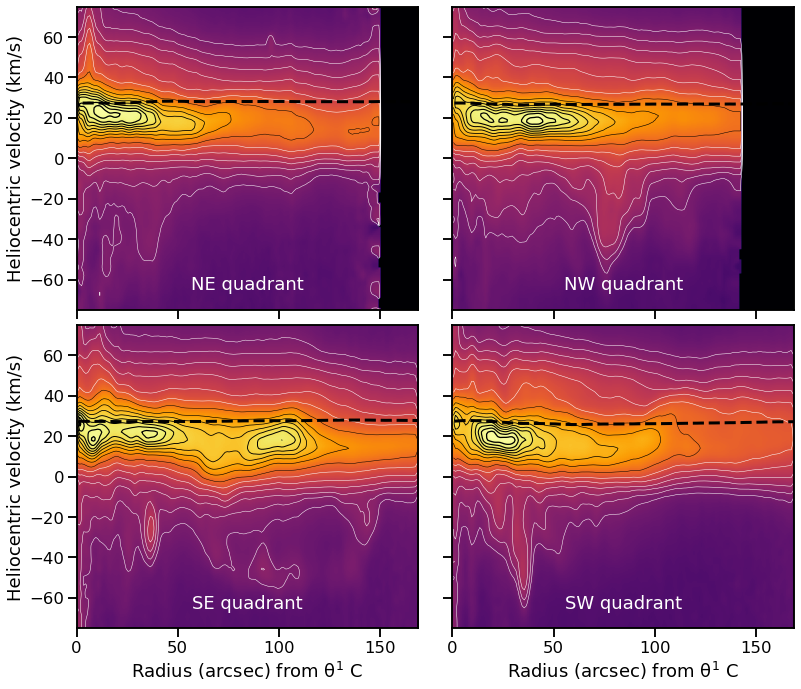

In [467]:
for qlabel, qmask in quadmasks.items():
    hists = []
    edges = []
    for plane in o3cube_hdu.data:
        mgood = (~m2A) & qmask
        mgood = mgood & np.isfinite(plane)
        mgood = mgood & (plane > 0.0)
        H, e = np.histogram(
            rad[mgood], 
            weights=plane[mgood], 
            bins=radbins,
        )
        H0, _ = np.histogram(
            rad[mgood], 
            bins=radbins,
        )
        hists.append(
            H / H0#/ np.nanmax(H)
        )
    hist_arr = np.stack(hists)
    hist_arr /= np.nanmax(hist_arr)
    hist_fine = np.empty((nfv, nr))
    print(hist_arr.shape, hist_fine.shape)

    for ir in range(nr):
        hist_fine[:, ir] = np.interp(finevels, vels, hist_arr[:, ir])
    #hist_arr /= np.nanmean(hist_arr, axis=0, keepdims=True)
    hist_arr_dict[qlabel] = convolve(hist_fine, kernel)


gamma = 6.0
centers = 0.5 * (radbins[1:] + radbins[:-1])
levels_hi = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
levels_lo = 0.1 * np.array([1 / 64, 1 / 32, 1 / 16, 1 / 8, 1 / 4, 1 / 2])

fig, axes = plt.subplots(
    2, 2, 
    figsize=(12, 10),
    sharex=True,
    sharey=True,
)
for qlabel, ax in zip(hist_arr_dict, axes.flat):
    hist_arr = hist_arr_dict[qlabel]
    hist_arr[~np.isfinite(hist_arr)] = 0.0
    print(qlabel, np.nanmax(hist_arr))
    ax.imshow(
        hist_arr**(1/gamma), 
        origin="lower",
        extent=[radbins[0], radbins[-1], vels[0], vels[-1]],
        vmin=0, vmax=1.0,
        cmap="inferno",
    )
    ax.contour(
        centers,
        finevels,
        hist_arr, 
        levels=levels_hi,
        colors="k",
        linewidths=0.5 + 0.1*np.arange(len(levels_hi)),
    )
    ax.contour(
        centers,
        finevels,
        hist_arr, 
        levels=levels_lo,
        colors="w",
        linewidths=0.5,
    )
    ax.plot(
        centers_co, 
        Vco_dict[qlabel], 
        lw=3, color="k", linestyle="dashed",
    )
    #ax.plot(centers, vmeans, color="c", lw=3)
    ax.set_aspect(1.)
    ax.set(
        ylim=[-75, 75],
    )
    ax.set_title(f"{qlabel} quadrant", y=0, pad=20, color="w")

for ax in axes[:, 0]:
    ax.set(ylabel="Heliocentric velocity (km/s)")
for ax in axes[1, :]:
    ax.set(xlabel="Radius (arcsec) from θ$^1$ C")
fig.tight_layout(h_pad=0.0, w_pad=0.0)
fig.savefig("../figs/v-hist-quadrant-oiii.pdf")
...;

Just for interest, we can also do it with the other lines:

<ipython-input-452-a3ad887fde10>:19: RuntimeWarning: invalid value encountered in true_divide
  H / H0#/ np.nanmax(H)


(61, 169) (240, 169)


(61, 169) (240, 169)
(61, 169) (240, 169)
(61, 169) (240, 169)
NE 0.9869251480807562
NW 0.990176323212662
SE 0.9758974159989499
SW 0.9910463996909448


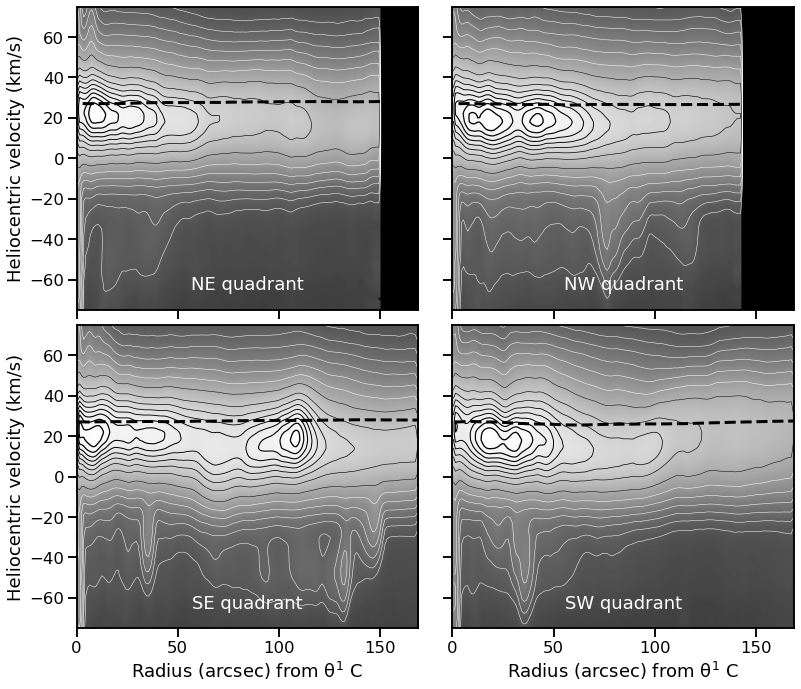

In [452]:
hacube_hdu = fits.open(LUIS_DATA_PATH / "vcube.ha-wcs-csub.fits")[0]
for qlabel, qmask in quadmasks.items():
    hists = []
    edges = []
    for plane in hacube_hdu.data:
        mgood = (~m2A) & qmask
        mgood = mgood & np.isfinite(plane)
        mgood = mgood & (plane > 0.0)
        H, e = np.histogram(
            rad[mgood], 
            weights=plane[mgood], 
            bins=radbins,
        )
        H0, _ = np.histogram(
            rad[mgood], 
            bins=radbins,
        )
        hists.append(
            H / H0#/ np.nanmax(H)
        )
    hist_arr = np.stack(hists)
    hist_arr /= np.nanmax(hist_arr)
    hist_fine = np.empty((nfv, nr))
    print(hist_arr.shape, hist_fine.shape)

    for ir in range(nr):
        hist_fine[:, ir] = np.interp(finevels, vels, hist_arr[:, ir])
    #hist_arr /= np.nanmean(hist_arr, axis=0, keepdims=True)
    hist_arr_dict[qlabel] = convolve(hist_fine, kernel)


gamma = 6.0
centers = 0.5 * (radbins[1:] + radbins[:-1])
levels_hi = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
levels_lo = 0.1 * np.array([1 / 64, 1 / 32, 1 / 16, 1 / 8, 1 / 4, 1 / 2])

fig, axes = plt.subplots(
    2, 2, 
    figsize=(12, 10),
    sharex=True,
    sharey=True,
)
for qlabel, ax in zip(hist_arr_dict, axes.flat):
    hist_arr = hist_arr_dict[qlabel]
    hist_arr[~np.isfinite(hist_arr)] = 0.0
    print(qlabel, np.nanmax(hist_arr))
    ax.imshow(
        hist_arr**(1/gamma), 
        origin="lower",
        extent=[radbins[0], radbins[-1], vels[0], vels[-1]],
        vmin=0, vmax=1.0,
        cmap="gray",
    )
    ax.contour(
        centers,
        finevels,
        hist_arr, 
        levels=levels_hi,
        colors="k",
        linewidths=0.5 + 0.1*np.arange(len(levels_hi)),
    )
    ax.contour(
        centers,
        finevels,
        hist_arr, 
        levels=levels_lo,
        colors="w",
        linewidths=0.5,
    )
    ax.plot(
        centers_co, 
        Vco_dict[qlabel], 
        lw=3, color="k", linestyle="dashed",
    )

    ax.set_aspect(1.)
    ax.set(
        ylim=[-75, 75],
    )
    ax.set_title(f"{qlabel} quadrant", y=0, pad=20, color="w")

for ax in axes[:, 0]:
    ax.set(ylabel="Heliocentric velocity (km/s)")
for ax in axes[1, :]:
    ax.set(xlabel="Radius (arcsec) from θ$^1$ C")
fig.tight_layout(h_pad=0.0, w_pad=0.0)
fig.savefig("../figs/v-hist-quadrant-ha.pdf")
...;

<ipython-input-454-8041b8909cde>:21: RuntimeWarning: invalid value encountered in true_divide
  H / H0#/ np.nanmax(H)


(61, 169) (240, 169)
(61, 169) (240, 169)


(61, 169) (240, 169)
(61, 169) (240, 169)
NE 0.967640998798613
NW 0.977956742401723
SE 0.9722969733292972
SW 0.9869285542938866


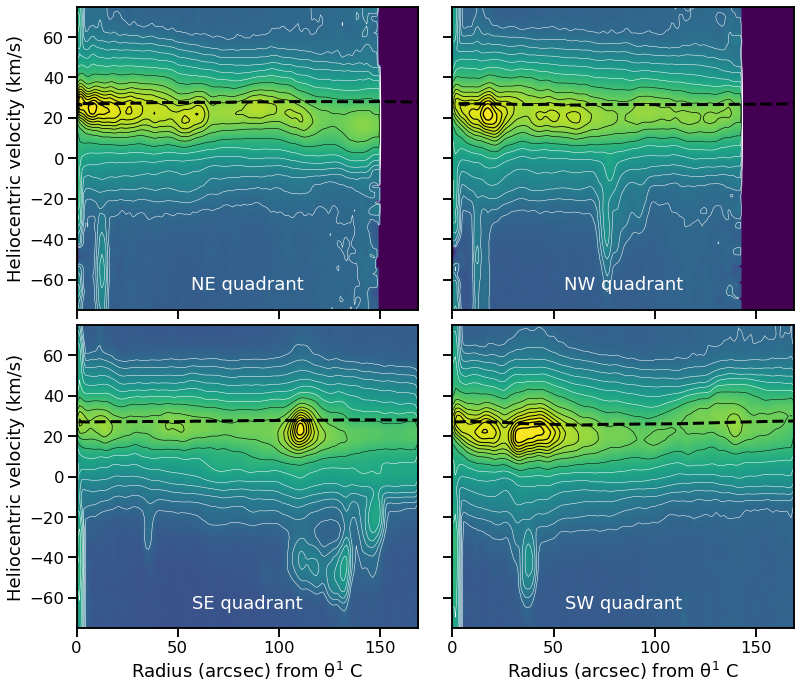

In [454]:
n2cube_hdu = fits.open(LUIS_DATA_PATH / "vcube.nii-wcs-csub.fits")[0]
wspec_nii = WCS(n2cube_hdu.header).spectral
vels_nii = wspec_nii.array_index_to_world(range(nv)).value
for qlabel, qmask in quadmasks.items():
    hists = []
    edges = []
    for plane in n2cube_hdu.data:
        mgood = (~m2A) & qmask
        mgood = mgood & np.isfinite(plane)
        mgood = mgood & (plane > 0.0)
        H, e = np.histogram(
            rad[mgood], 
            weights=plane[mgood], 
            bins=radbins,
        )
        H0, _ = np.histogram(
            rad[mgood], 
            bins=radbins,
        )
        hists.append(
            H / H0#/ np.nanmax(H)
        )
    hist_arr = np.stack(hists)
    hist_arr /= np.nanmax(hist_arr)
    hist_fine = np.empty((nfv, nr))
    print(hist_arr.shape, hist_fine.shape)

    for ir in range(nr):
        hist_fine[:, ir] = np.interp(finevels, vels_nii, hist_arr[:, ir])
    #hist_arr /= np.nanmean(hist_arr, axis=0, keepdims=True)
    hist_arr_dict[qlabel] = convolve(hist_fine, kernel)


gamma = 6.0
centers = 0.5 * (radbins[1:] + radbins[:-1])
levels_hi = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
levels_lo = 0.1 * np.array([1 / 64, 1 / 32, 1 / 16, 1 / 8, 1 / 4, 1 / 2])

fig, axes = plt.subplots(
    2, 2, 
    figsize=(12, 10),
    sharex=True,
    sharey=True,
)
for qlabel, ax in zip(hist_arr_dict, axes.flat):
    hist_arr = hist_arr_dict[qlabel]
    hist_arr[~np.isfinite(hist_arr)] = 0.0
    print(qlabel, np.nanmax(hist_arr))
    ax.imshow(
        hist_arr**(1/gamma), 
        origin="lower",
        extent=[radbins[0], radbins[-1], vels[0], vels[-1]],
        vmin=0, vmax=1.0,
        cmap="viridis",
    )
    ax.contour(
        centers,
        finevels,
        hist_arr, 
        levels=levels_hi,
        colors="k",
        linewidths=0.5 + 0.1*np.arange(len(levels_hi)),
    )
    ax.contour(
        centers,
        finevels,
        hist_arr, 
        levels=levels_lo,
        colors="w",
        linewidths=0.5,
    )
    ax.plot(
        centers_co, 
        Vco_dict[qlabel], 
        lw=3, color="k", linestyle="dashed",
    )

    ax.set_aspect(1.)
    ax.set(
        ylim=[-75, 75],
    )
    ax.set_title(f"{qlabel} quadrant", y=0, pad=20, color="w")

for ax in axes[:, 0]:
    ax.set(ylabel="Heliocentric velocity (km/s)")
for ax in axes[1, :]:
    ax.set(xlabel="Radius (arcsec) from θ$^1$ C")
fig.tight_layout(h_pad=0.0, w_pad=0.0)
fig.savefig("../figs/v-hist-quadrant-nii.pdf")
...;

It would be good to compare these with the CO